In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from vae.vae import SVAE
from vae.train import train,train_new
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from vae.predict import predict
from utils.utils_f4f import heatmap, si_format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


In [69]:
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family'] = ['sans-serif']
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['text.usetex'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#### Data_preparetion


In [70]:
# Import data 
assay = 'nor_package'
array = 'AA_sequence'

df_all = pd.read_csv('../data/1st_780w_packseq_aa.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df = df_all[['AA_sequence', 'nor_package']]
df= df.sort_values(by='nor_package')

#Fill in the nan data and replace the inf value
df['nor_package'] = df['nor_package'].fillna(0)  
df['nor_package'] = df['nor_package'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['nor_package','AA_sequence'])
df = df.iloc[::500]
df

,AA_sequence,nor_package
1467121,SRYSSKH,-8.48312
8590886,FRMSHSK,-7.18056
2519232,ICILDVL,-7.03920
8447804,LWHSVVG,-6.95174
3816202,LILFRLF,-6.88247
...,...,...
7582338,WGVSAAP,5.91863
5195113,GGVGRVV,6.08169
7540111,WDGEGRG,6.30093
5216835,GVHGKGL,6.61051


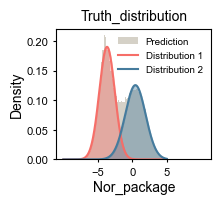

In [71]:
nor_package = df_all[np.isfinite(df_all[assay])][assay]
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

### Prep data 

`prep_data()` will one-hot encode the `AA_sequence` column and split the data into
training and test sets. The training split will be split
futher into training and validation batches with `make_tf_batches()`.


In [72]:
(data_list, train_df, test_df, prepped_df) = prep_data(df, AA_colname=array, target_assay_col=assay)
train_df['Y--nor_package'] = train_df['AA_sequence'].map(df.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])
test_df['Y--nor_package'] = test_df['AA_sequence'].map(df.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])
prepped_df['Y--nor_package'] = test_df['AA_sequence'].map(df.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])

In [73]:
train_df.isnull().describe()
prepped_df.isnull().describe()

,AA_sequence,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x132,x133,x134,x135,x136,x137,x138,x139,Y--nor_package,test
count,15611,15611,15611,15611,15611,15611,15611,15611,15611,15611,...,15611,15611,15611,15611,15611,15611,15611,15611,15611,15611
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
freq,15611,15611,15611,15611,15611,15611,15611,15611,15611,15611,...,15611,15611,15611,15611,15611,15611,15611,15611,14050,15611


Now we split `train_df` into TensorFlow-compatible training and validation batches using
`make_tf_batches()`. `unbatched_data` is a tuple of Numpy arrays corresponding to the X, Y
and CV (if using) values across both the training and validation batches.


In [74]:
X, Y  = data_list
train_batches, val_batches, unbatched_data = make_tf_batches(X, Y)

## VAE  model training

Default parameterization:Here the model is applied to aa-nor_package learning process, as details

- `input_dim = 140`
- `latent_dim = 2`
- `enc_hidden_dims = [100,40]`
- `dec_hidden_dims = [40,100]`
- `reg_hidden_dims = [100,10]`


In [75]:
# SVAE parameters (same as default)
input_dim = 140
latent_dim = 2
enc_hidden_dims = [100,40]
dec_hidden_dims = [40,100]
reg_hidden_dims = [100,10]

# training parameters 

outpath = 'pretrain/vae/1st_aa_nor_package'
loss_weights = [1.0,0.8,1.5] # [reconstruction, KL, regression]

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

# Initialize SVAE model (with default parameterizations)
model = SVAE(input_dim=140, latent_dim=2, enc_hidden_dims=[100,40], dec_hidden_dims=[40,100], reg_hidden_dims=[100,10], name='svae')
model.summary()

Model: "svae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 140)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  18304     ['encoder_input[0][0]',       
                              (None, 2),                             'encoder_input[0][0]']       
                              (None, 2)]                                                          
                                                                                                  
 tf.concat_7 (TFOpLambda)    (None, 142)                  0         ['encoder[1][0]',             
                                                                     'encoder_input[0][0]']    

The `train()` function returns the trained `model` and `preds_df`, a DataFrame of
regressor predictions on the X values in `unbatched_data`, along with their latent space
projections and their true Y values.

`train()` saves the trained model, as well as a log of the training and validation loss
values per epoch and `preds_df`, to disk. These saves will be made to an optional
parameter `model_outdir` - if not specified, `train()` will make a new,
informatively-named directory to write to (path is returned).

In [76]:
# Train model
model, preds_df, model_outdir = train_new(model, train_batches, val_batches, array,outpath,
                                        train_df, optimizer=optimizer,                    
                                        loss_weights=loss_weights           
                        )

Logging following metrics: ['train_model_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_regression_loss', 'val_model_loss', 'val_reconstruction_loss', 'val_kl_loss', 'val_regression_loss']


----- Beginning training. -----

epoch 1
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 26.2834 - train_reconstruction_loss: 20.4277 - train_kl_loss: 0.0108 - train_regression_loss: 3.8999 - val_model_loss: 25.8126 - val_reconstruction_loss: 20.3576 - val_kl_loss: 0.0016 - val_regression_loss: 3.6393


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 2
6248/6248 [==============================] - 53s 9ms/step - train_model_loss: 25.8307 - train_reconstruction_loss: 20.3677 - train_kl_loss: 7.4752e-04 - train_regression_loss: 3.6371 - val_model_loss: 25.5530 - val_reconstruction_loss: 20.3165 - val_kl_loss: 3.5173e-04 - val_regression_loss: 3.4833


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 3
6248/6248 [==============================] - 53s 8ms/step - train_model_loss: 25.5805 - train_reconstruction_loss: 20.3535 - train_kl_loss: 4.5205e-04 - train_regression_loss: 3.4817 - val_model_loss: 25.4821 - val_reconstruction_loss: 20.3762 - val_kl_loss: 4.4907e-04 - val_regression_loss: 3.3991


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 4
6248/6248 [==============================] - 53s 8ms/step - train_model_loss: 25.4431 - train_reconstruction_loss: 20.3680 - train_kl_loss: 4.1830e-04 - train_regression_loss: 3.3820 - val_model_loss: 25.1322 - val_reconstruction_loss: 20.3658 - val_kl_loss: 4.7406e-04 - val_regression_loss: 3.1754


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 5
6248/6248 [==============================] - 53s 8ms/step - train_model_loss: 25.2063 - train_reconstruction_loss: 20.3583 - train_kl_loss: 2.7250e-04 - train_regression_loss: 3.2333 - val_model_loss: 25.1490 - val_reconstruction_loss: 20.3866 - val_kl_loss: 2.1943e-04 - val_regression_loss: 3.1686


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 6
6248/6248 [==============================] - 54s 9ms/step - train_model_loss: 25.1168 - train_reconstruction_loss: 20.3527 - train_kl_loss: 2.1351e-04 - train_regression_loss: 3.1735 - val_model_loss: 24.9437 - val_reconstruction_loss: 20.3544 - val_kl_loss: 2.4736e-04 - val_regression_loss: 3.0561


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 7
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 25.0162 - train_reconstruction_loss: 20.3567 - train_kl_loss: 1.7418e-04 - train_regression_loss: 3.1065 - val_model_loss: 24.8871 - val_reconstruction_loss: 20.3310 - val_kl_loss: 1.3912e-04 - val_regression_loss: 3.0311


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 8
6248/6248 [==============================] - 54s 9ms/step - train_model_loss: 24.9699 - train_reconstruction_loss: 20.3552 - train_kl_loss: 1.2899e-04 - train_regression_loss: 3.0766 - val_model_loss: 24.6051 - val_reconstruction_loss: 20.3404 - val_kl_loss: 1.2265e-04 - val_regression_loss: 2.8376


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 9
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 24.8618 - train_reconstruction_loss: 20.3479 - train_kl_loss: 1.5891e-04 - train_regression_loss: 3.0169 - val_model_loss: 24.9258 - val_reconstruction_loss: 20.3643 - val_kl_loss: 1.4990e-04 - val_regression_loss: 3.0409


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 10
6248/6248 [==============================] - 52s 8ms/step - train_model_loss: 24.8457 - train_reconstruction_loss: 20.3616 - train_kl_loss: 1.8185e-04 - train_regression_loss: 2.9943 - val_model_loss: 24.5144 - val_reconstruction_loss: 20.3617 - val_kl_loss: 2.7749e-04 - val_regression_loss: 2.7780


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 11
6248/6248 [==============================] - 53s 9ms/step - train_model_loss: 24.7527 - train_reconstruction_loss: 20.3596 - train_kl_loss: 2.2002e-04 - train_regression_loss: 2.9258 - val_model_loss: 24.7387 - val_reconstruction_loss: 20.3479 - val_kl_loss: 5.1097e-04 - val_regression_loss: 2.9216


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 12
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 24.6864 - train_reconstruction_loss: 20.3614 - train_kl_loss: 3.6578e-04 - train_regression_loss: 2.8839 - val_model_loss: 24.7073 - val_reconstruction_loss: 20.3583 - val_kl_loss: 2.9297e-04 - val_regression_loss: 2.9064


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 13
6248/6248 [==============================] - 53s 8ms/step - train_model_loss: 24.6043 - train_reconstruction_loss: 20.3516 - train_kl_loss: 3.9991e-04 - train_regression_loss: 2.8417 - val_model_loss: 24.2174 - val_reconstruction_loss: 20.3332 - val_kl_loss: 1.3107e-04 - val_regression_loss: 2.5843


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 14
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 24.4986 - train_reconstruction_loss: 20.3499 - train_kl_loss: 2.4487e-04 - train_regression_loss: 2.7629 - val_model_loss: 24.0693 - val_reconstruction_loss: 20.3410 - val_kl_loss: 3.1143e-04 - val_regression_loss: 2.4854


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 15
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 24.4507 - train_reconstruction_loss: 20.3510 - train_kl_loss: 3.3765e-04 - train_regression_loss: 2.7312 - val_model_loss: 24.0445 - val_reconstruction_loss: 20.3724 - val_kl_loss: 6.3920e-04 - val_regression_loss: 2.4437


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 16
6248/6248 [==============================] - 54s 9ms/step - train_model_loss: 24.3241 - train_reconstruction_loss: 20.3554 - train_kl_loss: 4.2825e-04 - train_regression_loss: 2.6530 - val_model_loss: 23.9968 - val_reconstruction_loss: 20.3673 - val_kl_loss: 4.8421e-04 - val_regression_loss: 2.4193


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 17
6248/6248 [==============================] - 55s 9ms/step - train_model_loss: 24.2147 - train_reconstruction_loss: 20.3482 - train_kl_loss: 0.0022 - train_regression_loss: 2.5768 - val_model_loss: 24.0359 - val_reconstruction_loss: 20.3348 - val_kl_loss: 3.3840e-04 - val_regression_loss: 2.4659


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 18
6248/6248 [==============================] - 52s 8ms/step - train_model_loss: 24.0757 - train_reconstruction_loss: 20.3451 - train_kl_loss: 3.0149e-04 - train_regression_loss: 2.4917 - val_model_loss: 23.7759 - val_reconstruction_loss: 20.3096 - val_kl_loss: 4.9207e-04 - val_regression_loss: 2.3078


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 19
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 23.9976 - train_reconstruction_loss: 20.3479 - train_kl_loss: 1.7187e-04 - train_regression_loss: 2.4319 - val_model_loss: 23.9864 - val_reconstruction_loss: 20.3442 - val_kl_loss: 1.9037e-04 - val_regression_loss: 2.4269


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 20
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 23.8671 - train_reconstruction_loss: 20.3481 - train_kl_loss: 1.9480e-04 - train_regression_loss: 2.3479 - val_model_loss: 23.5159 - val_reconstruction_loss: 20.3581 - val_kl_loss: 1.6577e-04 - val_regression_loss: 2.1061


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 21
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 23.7587 - train_reconstruction_loss: 20.3561 - train_kl_loss: 3.0934e-04 - train_regression_loss: 2.2731 - val_model_loss: 23.5469 - val_reconstruction_loss: 20.3346 - val_kl_loss: 5.8368e-04 - val_regression_loss: 2.1407


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 22
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 23.5774 - train_reconstruction_loss: 20.3521 - train_kl_loss: 0.0020 - train_regression_loss: 2.1480 - val_model_loss: 23.1906 - val_reconstruction_loss: 20.3380 - val_kl_loss: 3.9725e-04 - val_regression_loss: 1.9041


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 23
6248/6248 [==============================] - 53s 8ms/step - train_model_loss: 23.4838 - train_reconstruction_loss: 20.3515 - train_kl_loss: 4.4389e-04 - train_regression_loss: 2.0890 - val_model_loss: 23.2990 - val_reconstruction_loss: 20.3734 - val_kl_loss: 0.0014 - val_regression_loss: 1.9478


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 24
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 23.3645 - train_reconstruction_loss: 20.3462 - train_kl_loss: 3.6050e-04 - train_regression_loss: 2.0101 - val_model_loss: 23.0198 - val_reconstruction_loss: 20.3587 - val_kl_loss: 2.6231e-04 - val_regression_loss: 1.7794


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 25
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 23.2365 - train_reconstruction_loss: 20.3587 - train_kl_loss: 1.9493e-04 - train_regression_loss: 1.9204 - val_model_loss: 22.9249 - val_reconstruction_loss: 20.3628 - val_kl_loss: 4.4238e-04 - val_regression_loss: 1.7092


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 26
6248/6248 [==============================] - 52s 8ms/step - train_model_loss: 23.1378 - train_reconstruction_loss: 20.3527 - train_kl_loss: 4.0764e-04 - train_regression_loss: 1.8546 - val_model_loss: 22.9143 - val_reconstruction_loss: 20.3714 - val_kl_loss: 5.4446e-04 - val_regression_loss: 1.6931


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 27
6248/6248 [==============================] - 52s 8ms/step - train_model_loss: 22.9912 - train_reconstruction_loss: 20.3452 - train_kl_loss: 0.0011 - train_regression_loss: 1.7658 - val_model_loss: 22.7955 - val_reconstruction_loss: 20.3243 - val_kl_loss: 2.9372e-04 - val_regression_loss: 1.6472


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 28
6248/6248 [==============================] - 55s 9ms/step - train_model_loss: 22.9141 - train_reconstruction_loss: 20.3549 - train_kl_loss: 3.3029e-04 - train_regression_loss: 1.7080 - val_model_loss: 22.6939 - val_reconstruction_loss: 20.3463 - val_kl_loss: 4.7226e-04 - val_regression_loss: 1.5650


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 29
6248/6248 [==============================] - 52s 8ms/step - train_model_loss: 22.8292 - train_reconstruction_loss: 20.3510 - train_kl_loss: 2.3141e-04 - train_regression_loss: 1.6545 - val_model_loss: 22.4886 - val_reconstruction_loss: 20.3582 - val_kl_loss: 2.1318e-04 - val_regression_loss: 1.4180


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 30
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 22.7186 - train_reconstruction_loss: 20.3514 - train_kl_loss: 5.5617e-04 - train_regression_loss: 1.5781 - val_model_loss: 22.3955 - val_reconstruction_loss: 20.3540 - val_kl_loss: 5.4592e-04 - val_regression_loss: 1.3591


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1]

epoch 31
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 22.5744 - train_reconstruction_loss: 20.3460 - train_kl_loss: 1.8140e-04 - train_regression_loss: 1.4863 - val_model_loss: 22.2868 - val_reconstruction_loss: 20.3304 - val_kl_loss: 1.8350e-04 - val_regression_loss: 1.3072


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1, 1]

epoch 32
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 22.4961 - train_reconstruction_loss: 20.3513 - train_kl_loss: 1.9860e-04 - train_regression_loss: 1.4292 - val_model_loss: 22.1697 - val_reconstruction_loss: 20.3436 - val_kl_loss: 1.7105e-04 - val_regression_loss: 1.2191


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1, 1, 0]

epoch 33
6248/6248 [==============================] - 54s 9ms/step - train_model_loss: 22.3575 - train_reconstruction_loss: 20.3408 - train_kl_loss: 2.1735e-04 - train_regression_loss: 1.3438 - val_model_loss: 22.1259 - val_reconstruction_loss: 20.3206 - val_kl_loss: 1.9706e-04 - val_regression_loss: 1.2057


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1, 1, 0, 1]

epoch 34
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 22.3551 - train_reconstruction_loss: 20.3470 - train_kl_loss: 2.8478e-04 - train_regression_loss: 1.3374 - val_model_loss: 22.1035 - val_reconstruction_loss: 20.3649 - val_kl_loss: 2.2267e-04 - val_regression_loss: 1.1580


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1, 1, 0, 1, 0]

epoch 35
6248/6248 [==============================] - 52s 8ms/step - train_model_loss: 22.2336 - train_reconstruction_loss: 20.3574 - train_kl_loss: 4.9070e-04 - train_regression_loss: 1.2496 - val_model_loss: 21.9696 - val_reconstruction_loss: 20.3488 - val_kl_loss: 0.0065 - val_regression_loss: 1.0796


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1, 1, 0, 1, 0, 0]

epoch 36
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 22.1895 - train_reconstruction_loss: 20.3582 - train_kl_loss: 0.0014 - train_regression_loss: 1.2203 - val_model_loss: 22.0689 - val_reconstruction_loss: 20.3547 - val_kl_loss: 0.0015 - val_regression_loss: 1.1401


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1, 1, 0, 1, 0, 0, 1]

epoch 37
6248/6248 [==============================] - 51s 8ms/step - train_model_loss: 22.1364 - train_reconstruction_loss: 20.3465 - train_kl_loss: 0.0013 - train_regression_loss: 1.1954 - val_model_loss: 21.8609 - val_reconstruction_loss: 20.3270 - val_kl_loss: 3.1266e-04 - val_regression_loss: 1.0203


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1, 1, 0, 1, 0, 0, 1, 1]

epoch 38
6248/6248 [==============================] - 52s 8ms/step - train_model_loss: 22.0462 - train_reconstruction_loss: 20.3558 - train_kl_loss: 2.6649e-04 - train_regression_loss: 1.1271 - val_model_loss: 21.8705 - val_reconstruction_loss: 20.3432 - val_kl_loss: 2.0305e-04 - val_regression_loss: 1.0180


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1, 1, 0, 1, 0, 0, 1, 1, 0]

epoch 39
6248/6248 [==============================] - 52s 8ms/step - train_model_loss: 22.0183 - train_reconstruction_loss: 20.3560 - train_kl_loss: 0.0014 - train_regression_loss: 1.1071 - val_model_loss: 21.7991 - val_reconstruction_loss: 20.3398 - val_kl_loss: 8.2660e-04 - val_regression_loss: 0.9724


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [1, 1, 0, 1, 0, 0, 1, 1, 0, 1]

epoch 40
6248/6248 [==============================] - 52s 8ms/step - train_model_loss: 21.9405 - train_reconstruction_loss: 20.3582 - train_kl_loss: 2.6798e-04 - train_regression_loss: 1.0547 - val_model_loss: 21.7869 - val_reconstruction_loss: 20.3544 - val_kl_loss: 2.5007e-04 - val_regression_loss: 0.9552


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Hit maximum epochs.
Finished training model. Final overall losses:
train: 21.940    val:21.787
440/440 [==============================] - 0s 593us/step

MSE of predictions vs true labels: 0.9037927985191345


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_21.94T_21.79V\model\assets


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_21.94T_21.79V\model\assets


Model saved to e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_21.94T_21.79V\model.
Losses saved to e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_21.94T_21.79V\loss_log.csv.
Train predictions saved to e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_21.94T_21.79V\preds.csv.


####  Correlation between result and prediction 

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


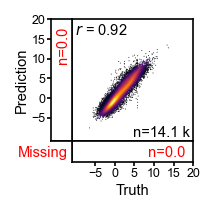

In [77]:


x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=100, random_state=1), 
    y_both.sample(n=100, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/1st_results/nor_package/1st_vae_aa_nor_package_correlation_train.pdf',dpi=300,bbox_inches='tight')
plt.show()

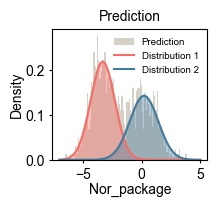

In [82]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/1st_results/nor_package/1st_vae_prediction_nor_package_distribution_train.pdf',dpi=300,bbox_inches='tight')

In [83]:
AA = test_df[array].values
X = test_df.drop(columns=[array,'Y--nor_package'])
Y = test_df['Y--nor_package'].values
preds_df = predict(model, X,array, Y=Y, AA=AA)
preds_df['y_pred'].corr(preds_df['y_true'])

49/49 [==============================] - 0s 626us/step

MSE of predictions vs true labels: 0.9807030558586121


0.9120682341049854

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


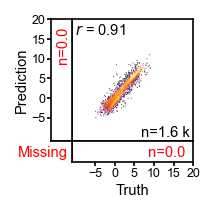

In [84]:


x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=19, random_state=1), 
    y_both.sample(n=19, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/1st_results/nor_package/1st_vae_aa_nor_package_correlation_test.pdf',dpi=300,bbox_inches='tight')



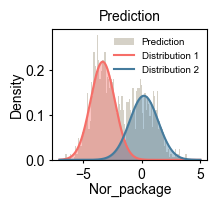

In [85]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/1st_results/nor_package/1st_vae_prediction_nor_package_distribution_test.pdf',dpi=300,bbox_inches='tight')